In [1]:
%matplotlib inline
import scipy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


import scipy

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid, sub_sample_data

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import scipy
import functools

import scipy

# from sklearn import datasets
# from sklearn.preprocessing import LabelBinarizer

In [3]:
    beta = 0.2
    r = 0.6
    delta = 0.15
    theta = np.array([beta, r, delta]) # true parameter settings
    #theta = np.random.randn(3)
    print(theta)
    
    
    
    

[0.2  0.6  0.15]


In [4]:
def odeFunc(t,x):
    N = 1000
    S = x[0]
    I = x[1]
    R = x[2]
    y0 = delta*N - delta*S - beta*I*S  # del S
    y1 = beta*I*S - (r+delta)*I        # del I
    y2 = r*I - delta*R                 # del R
    return y0,y1,y2

In [5]:
def solverFunc():
    timeVec = np.linspace(0,6,61)
    S_0 = 900
    I_0 = 100
    R_0 = 0
    x_0 = np.array([S_0, I_0, R_0])
    soln = scipy.integrate.solve_ivp(odeFunc,[0,6],x_0,t_eval=timeVec,method='RK45')
    return soln

In [6]:
soln = solverFunc()
data1 = np.zeros([61,1])
stdNoise = 50 
for ii in range (0,len(data1)):
    data1[ii]=soln.y[1,ii]+stdNoise*np.random.randn()

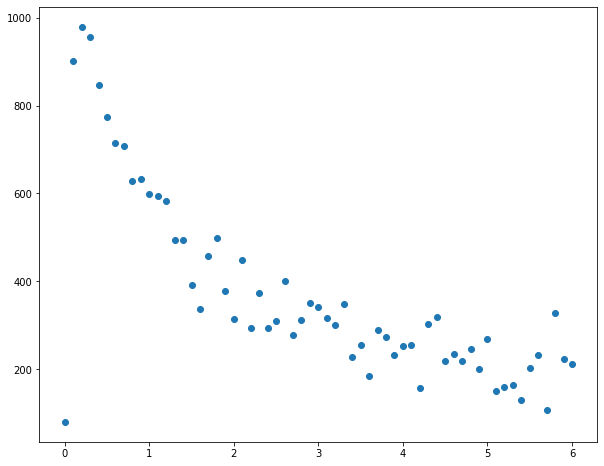

In [7]:
plt.figure(figsize=(10,8))
plt.scatter(soln.t,data1)
plt.show()

In [14]:
# theta0 = np.random.randn(3)
# print(theta0)

In [8]:
def SIR(t, y, beta, r, delta, N=1000):
    #S, I, R = y
    dSdt = delta*N - delta*y[0] - beta*y[1]*y[0]
    dIdt = beta*y[1]*y[0] - (r+delta)*y[1]
    dRdt = r*y[1] - delta*y[2]
    
    return dSdt, dIdt, dRdt



In [9]:
def log_likelihood(thetain,data):
    timeVec = np.linspace(0,6,61)
    beta = thetain[0]
    r = thetain[1]
    delta = thetain[2]
    S_0 = 900
    I_0 = 100
    R_0 = 0
    N = 1000
    x_0 = np.array([S_0, I_0, R_0])
#     soln = scipy.integrate.solve_ivp(odeFunc,[0,6],x_0,t_eval=timeVec, args=(beta, r, delta),method='RK45')
    sol = scipy.integrate.solve_ivp(SIR, [0,6], y0=x_0, method='RK45', args=(beta, r, delta), t_eval=timeVec)

    #if np.any(soln.y<0) or np.any(soln.y>N)
    #return 0
#     print(np.round(np.sum(soln.y,axis=0)))
    if np.any(np.round(np.sum(soln.y,axis=0))!=N):
        return -np.inf
    if theta[0] < 0 or theta[1] < 0 or theta[2] < 0:
        return -np.inf

    else:
        std = 50
        pre_exp_term = 1/(np.sqrt(2*np.pi)*std)
        exp_term = -0.5*np.square((data.T-soln.y[1])/std)
#     f = pre_exp_term*np.exp(exp_term)
        f = np.log(pre_exp_term)+exp_term
#         f = np.log(scipy.stats.norm.pdf(soln.y[1,:],data.T, std))
  
    
        f = np.log(scipy.stats.norm.pdf(data, soln.y[1], std))


        f_theta0 = (np.log(scipy.stats.norm.pdf(thetain[0],0,1)))
        f_theta1 = (np.log(scipy.stats.norm.pdf(thetain[1],0,1)))
        f_theta2 = (np.log(scipy.stats.norm.pdf(thetain[2],0,1)))
        f_theta = np.sum(np.array([f_theta0, f_theta1, f_theta2]))
  
        out=np.sum(f) + f_theta

    return out

In [10]:
logpost = lambda params: log_likelihood(params, data1)

In [11]:
def logmultivargaussianPDF(x,y,cov):
        logpdf = np.log(np.exp(-0.5*np.dot((x-y).T,np.dot(np.linalg.inv(cov),(x-y))))*1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov)))) 
        return logpdf

In [12]:
class DelayedRejectionAdaptiveMetropolis:
    
    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7): 
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.38**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
        
        self.sample_mean = self.samples[0,:]
        
    def sample(self, initial_sample, num_samples,D):
    
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
        
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample,D)
        
        accept = 1
        for ii in range(1, num_samples):
            
            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y,D)
            
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
    
            u = np.random.rand()
        
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                # propose
                chollev2 = np.linalg.cholesky(0.5*self.cov) # sqrt of the covariance
                y2 = self.samples[ii-1, :] + np.dot(chollev2, np.random.randn(self.dim))
                y_logpdf2 = self.logpdf(y2,D)
                
                a1y2y1 = np.exp(y_logpdf-y_logpdf2)
                a1xy1 = np.exp(y_logpdf - self.logpdf_vals[ii-1])
                
                qterm1 = logmultivargaussianPDF(y,y2,self.cov)
                qterm2 = logmultivargaussianPDF(y,self.samples[ii-1, :],self.cov) 
                
                a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + qterm1 - qterm2)
                a2 = min(a2,1)
                
                u2 = np.random.rand()

                if u2 < a2: # accept
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y_logpdf2
                    accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
                    
            self.num_samples += 1
            #print(ii, accept / self.num_samples, self.samples[ii, :])
             
            
            # adapt covariance if its time
            if ii > self.t0 and ii % self.freq == 0:                          
                sample_mean_new = (1/(ii+1))*self.samples[ii, :]+(ii/(ii+1))*self.sample_mean
                update_term = self.eps*np.eye(self.dim) + ii*np.dot(self.sample_mean,self.sample_mean) - (
                    ii+1)*np.dot(sample_mean_new,sample_mean_new) + np.dot(self.samples[ii, :],self.samples[ii, :])
                self.cov = (ii-1)*self.cov/ii + self.sd*update_term/ii 
                self.cov_chol = np.linalg.cholesky(self.cov)
                self.sample_mean = sample_mean_new
        
                                
            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
                
        return self.samples

In [13]:
def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation, 
        returning the MAP point and an approximation of the covariance
        
    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior
    
    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    # Gradient free method to obtain optimum
    res = scipy.optimize.minimize(neg_post, initial_guess, method='Nelder-Mead') 
    # Gradient method which also approximates the inverse of the hessian
    res = scipy.optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

In [14]:
class DRAM:
   
    def __init__(self, logpdf, cov, t0=100, freq=5, sd=None, max_samples=10000, eps=1e-7):
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        # self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
        
    def proposal_rw_logpdf(x, y, std=1.0, i=2):
        """Probability of moving from x to y (in this case it is symmetric)"""
        delta = x - y
        i = .5**i
        logpdf = -0.5*np.dot(delta, delta)/(i*std*std)
        return logpdf
       
    def sample(self, initial_sample, samples_requested, D):
   
        #assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample, D)
       
        accept = 0
        for ii in range(1, samples_requested):
           
            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y, D)
           
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
   
            u = np.random.rand()
           
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                # propose
                chollev2 = np.linalg.cholesky(0.5*self.cov) # sqrt of the covariance
                y2 = self.samples[ii-1, :] + np.dot(chollev2, np.random.randn(self.dim))
                y_logpdf2 = self.logpdf(y2, D)
                
                a1y2y1 = np.exp(y_logpdf-y_logpdf2)
                a1xy1 = np.exp(y_logpdf - self.logpdf_vals[ii-1])
                
                qterm1 = logmultivargaussianPDF(y,y2,self.cov)
                qterm2 = logmultivargaussianPDF(y,self.samples[ii-1, :],self.cov)
                
                a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + qterm1 - qterm2)
                a2 = min(a2,1)
                
                u2 = np.random.rand()

                if u2 < a2: # accept
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y_logpdf2
                    accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
            #print(ii, self.samples[ii,:])
               
            self.num_samples += 1
            print(ii, accept / self.num_samples, self.samples[ii, :])


            # adapt covariance if its time
            if ii > self.t0 and ii % self.freq == 0:
                # THE NEXT TWO LINES ARE UNACCEPTABLE IN YOUR PROJECT
                sample_cov = np.cov(self.samples[:self.num_samples,:],rowvar=False)
                self.cov = self.sd * ( sample_cov + self.eps * np.eye(self.dim))
                self.cov_chol = np.linalg.cholesky(self.cov)
               
            if ii % 500 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
               
        return self.samples, accept / float(self.num_samples)

In [15]:
def log_likelihood_I(theta, I_noisy):

    # estimate I given theta
    beta, r, delta = theta
    N = 1000
    y0 = np.array([900, 100, 0])
    t = np.linspace(0, 6, 61)
    
    sol = scipy.integrate.solve_ivp(SIR, [0,6], y0=y0, method='RK45', args=(beta, r, delta), t_eval=t)

    I_est = sol.y[1]
    for ii in range(61):
        if (np.round(np.sum(sol.y[:, ii])) != N):
            return -np.inf
        
    
    #if theta[0] < 0 or theta[1] < 0 or theta[2] < 0:
    #    return -np.inf
    
    # calculate likelihood
    sigma2 = 50
    pdf_I = 1 / (np.sqrt(2 * np.pi * sigma2))
    f_D_theta = 0
    f_d_theta = np.zeros(len(I_est))
    
    for i in range(len(I_est)):
        f_d_theta[i] = scipy.stats.norm.pdf(I_est[i], I_noisy[i], sigma2)

    f_d_theta = np.log(f_d_theta)
    f_D_theta = np.sum(f_d_theta)
    #f_D_theta = np.exp(f_D_theta)
    f_theta0 = scipy.stats.norm.pdf(beta, 0, sigma2)
    f_theta1 = scipy.stats.norm.pdf(r, 0, sigma2)
    f_theta2 = scipy.stats.norm.pdf(delta, 0, sigma2)
    f_theta = np.array([f_theta0, f_theta1, f_theta2])
    f_theta = np.prod(f_theta)
    f_Theta = np.log(f_theta)
    #print(f_D_theta + f_theta)
    
    return (f_D_theta + f_Theta)

In [ ]:
num_samples = 10000
# initial_sample = map_point
# covin = cov_laplace
initial_sample=np.array([0.015, .7, .25])
covin = np.diag(np.array([1e-3, 1e-3, 1e-3]))
covin = np.array([[3.13e-06, -1.3e-05, -3.9e-06],[-1.3e-05, 5.6e-04,1.6e-04],[-3.9e-06,1.6e-04,9.1e-05]])
print(covin)

# dram = DelayedRejectionAdaptiveMetropolis(logpost, cov, freq=5, t0=100, sd = None, eps = 1e-7, max_samples=num_samples)
dram = DelayedRejectionAdaptiveMetropolis(log_likelihood, covin, freq=5, t0=300, sd = None, eps = 1e-7, max_samples=num_samples)
#dram = DRAM(log_likelihood_I, covin, freq=5, t0=100, sd = None, eps = 1e-7, max_samples=num_samples)


data = data1
samples = dram.sample(initial_sample,num_samples,data)
print(samples)


[[ 3.13e-06 -1.30e-05 -3.90e-06]
 [-1.30e-05  5.60e-04  1.60e-04]
 [-3.90e-06  1.60e-04  9.10e-05]]
1 1.0 [0.01551383 0.68949366 0.24295907]
2 1.0 [0.01653224 0.6795062  0.24125809]
3 1.0 [0.01377738 0.67275753 0.23293113]
4 1.0 [0.01295249 0.66820313 0.22709894]
5 1.0 [0.01276837 0.64100974 0.21763753]
6 1.0 [0.01202931 0.66022296 0.22676605]
7 1.0 [0.01113741 0.67028002 0.22520937]
8 1.0 [0.01245484 0.67316264 0.22441411]
9 1.0 [0.01149712 0.6787539  0.22938157]
10 1.0 [0.01296554 0.68914229 0.23690604]
11 1.0 [0.0110655  0.670326   0.23204361]
12 1.0 [0.00902754 0.68908107 0.24206558]
13 1.0 [0.00620701 0.69077056 0.2294398 ]
14 1.0 [0.00687863 0.67354455 0.23491934]
15 1.0 [0.00761125 0.65573666 0.21931158]
16 1.0 [0.00698266 0.63351075 0.20722303]
17 1.0 [0.0075696  0.63231692 0.21801079]
18 1.0 [0.00838217 0.61287408 0.21636327]
19 1.0 [0.0090125  0.63765375 0.21907132]
20 1.0 [0.01193074 0.60358611 0.21308427]
21 1.0 [0.01772812 0.61541568 0.2180048 ]
22 1.0 [0.01808347 0.629990

222 1.0 [0.02804944 0.94830566 0.4214409 ]
223 1.0 [0.02949175 0.92104224 0.41489209]
224 1.0 [0.02907299 0.93034798 0.40919312]
225 1.0 [0.02836486 0.96268645 0.40803999]
226 1.0 [0.0295518  0.9515861  0.41946526]
227 1.0 [0.03052806 0.96109927 0.41669646]
228 1.0 [0.03090178 0.99606593 0.43315128]
229 1.0 [0.0307113  0.97915153 0.43464389]
230 1.0 [0.03464545 0.93649035 0.42875441]
231 1.0 [0.03272735 0.94155947 0.43744163]
232 1.0 [0.03013836 0.9811857  0.44617568]
233 1.0 [0.03239263 0.96237519 0.43923361]
234 1.0 [0.03079772 0.97257798 0.44020376]
235 1.0 [0.03403496 0.95777221 0.42592002]
236 1.0 [0.03699483 1.00217196 0.42250157]
237 1.0 [0.03785846 0.99000348 0.4185623 ]
238 1.0 [0.03929311 0.99473836 0.40508065]
239 1.0 [0.03868755 1.00214847 0.40113956]
240 1.0 [0.03831981 1.02536844 0.3988412 ]
241 1.0 [0.03972215 1.02358429 0.38628077]
242 0.9958677685950413 [0.03972215 1.02358429 0.38628077]
243 0.9958847736625515 [0.04117743 1.01367608 0.36035718]
244 0.9959016393442623 [

378 0.9947089947089947 [0.10107232 1.09722871 0.28337492]
379 0.9947229551451188 [0.02328323 1.00135377 0.1895327 ]
380 0.9947368421052631 [0.07805507 1.06471839 0.24102335]
381 0.994750656167979 [0.12730455 1.0895027  0.28759429]
382 0.9947643979057592 [0.05619016 1.0175127  0.20839176]
383 0.9947780678851175 [0.18275127 1.14449493 0.3318247 ]
384 0.9947916666666666 [0.18053141 1.1282557  0.30934793]
385 0.9948051948051948 [0.11722515 1.0293874  0.23119849]
386 0.9948186528497409 [0.36344461 1.27795483 0.47495784]
387 0.9948320413436692 [0.36720992 1.30378119 0.47538046]
388 0.9948453608247423 [0.30469659 1.23319123 0.40550315]
389 0.9948586118251928 [0.19645699 1.11470334 0.28103839]
390 0.9948717948717949 [-0.08419956  0.83617026  0.01397766]
391 0.9948849104859335 [0.01509429 0.93154372 0.10536144]
392 0.9948979591836735 [-0.12665568  0.72789882 -0.06786937]
393 0.9949109414758269 [-0.2087913   0.59272152 -0.1572742 ]
394 0.9949238578680203 [-0.3011605   0.50262574 -0.25500067]
395

519 0.9903660886319846 [1.03013005 1.36574015 0.97281149]
520 0.9884615384615385 [1.03013005 1.36574015 0.97281149]
521 0.9884836852207294 [0.25782051 0.57623326 0.19093252]
522 0.9885057471264368 [0.2121575  0.57553488 0.15863528]
523 0.988527724665392 [0.12970314 0.51199784 0.07756448]
524 0.9885496183206107 [0.46872996 0.87927753 0.42682584]
525 0.9885714285714285 [0.55976715 0.96451363 0.51102551]
526 0.9885931558935361 [0.69593367 1.09249329 0.64918562]
527 0.9886148007590133 [0.51304292 0.92809604 0.46510857]
528 0.9886363636363636 [0.19906116 0.64589156 0.15358624]
529 0.9886578449905482 [-0.09293848  0.38916133 -0.11827954]
530 0.9886792452830189 [-0.60197541 -0.10309339 -0.61949034]
531 0.9887005649717514 [-0.71364696 -0.22023391 -0.72684606]
532 0.9887218045112782 [-0.87938699 -0.40714858 -0.9031735 ]
533 0.9887429643527205 [-0.81408603 -0.34086975 -0.84065004]
534 0.9887640449438202 [-1.25185766 -0.73302344 -1.27874117]
535 0.9887850467289719 [-1.45951161 -0.93665311 -1.4850

/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_1211/3389915399.py:59: RuntimeWarning: invalid value encountered in log
  a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + qterm1 - qterm2)


605 0.9801652892561984 [1.55202542 2.11478951 1.42996411]
606 0.9801980198019802 [ 0.05390559  0.60249804 -0.0714495 ]
607 0.9802306425041186 [-0.16368238  0.40000106 -0.28011326]
608 0.9802631578947368 [-0.1671398   0.40625287 -0.2866906 ]
609 0.9802955665024631 [0.14688456 0.69859616 0.01203314]
610 0.978688524590164 [0.14688456 0.69859616 0.01203314]
611 0.9787234042553191 [0.93089999 1.53448912 0.81679844]
612 0.9787581699346405 [0.37433912 0.99502913 0.26137371]
613 0.9787928221859706 [0.14185078 0.76282931 0.02355115]
614 0.9771986970684039 [0.14185078 0.76282931 0.02355115]
615 0.9772357723577236 [0.77011093 1.38692253 0.6648763 ]
616 0.9772727272727273 [-0.12007112  0.53480559 -0.20873918]
617 0.9773095623987034 [-0.29460352  0.36260563 -0.3817078 ]
618 0.9773462783171522 [-0.23858061  0.42338613 -0.32439402]
619 0.9773828756058158 [0.27279765 0.9241779  0.18399419]
620 0.9774193548387097 [-0.8161507  -0.19384389 -0.92232443]
621 0.9774557165861514 [ 0.08943613  0.72666695 -0.0

743 0.9609690444145357 [-0.56016991  0.11165223 -0.54962893]
744 0.9596774193548387 [-0.56016991  0.11165223 -0.54962893]
745 0.959731543624161 [ 0.00146277  0.65807176 -0.00822387]
746 0.9584450402144772 [ 0.00146277  0.65807176 -0.00822387]
747 0.9571619812583668 [ 0.00146277  0.65807176 -0.00822387]
748 0.9572192513368984 [0.51372237 1.18073155 0.5084699 ]
749 0.9572763684913218 [-0.09598591  0.52974684 -0.11173586]
750 0.9573333333333334 [0.10346257 0.73039128 0.08717814]
751 0.9573901464713716 [-0.54098106  0.14322361 -0.53768668]
752 0.9574468085106383 [-0.64904786  0.04583861 -0.64325797]
753 0.9575033200531209 [-0.56667516  0.1312881  -0.56499998]
754 0.9575596816976127 [0.03493625 0.75479388 0.04509054]
755 0.9576158940397351 [-0.03749749  0.66095704 -0.03420213]
756 0.9576719576719577 [-0.62234777  0.07693222 -0.62642556]
757 0.9577278731836195 [0.16584166 0.86528075 0.16399994]
758 0.9577836411609498 [-0.89545856 -0.20396997 -0.89356483]
759 0.9565217391304348 [-0.89545856 -

889 0.9302587176602924 [-0.17836938  0.51693934 -0.15276764]
890 0.9303370786516854 [-0.94633471 -0.26157746 -0.91483894]
891 0.9304152637485971 [-0.88319958 -0.17489023 -0.83826607]
892 0.9304932735426009 [-0.86443393 -0.18798488 -0.82647484]
893 0.9294512877939529 [-0.86443393 -0.18798488 -0.82647484]
894 0.9295302013422819 [-0.90833091 -0.2392537  -0.87528596]
895 0.929608938547486 [-1.0155006  -0.37119364 -0.99231763]
896 0.9296875 [-1.27120652 -0.64064545 -1.25217393]
897 0.9297658862876255 [-0.5267922   0.14430976 -0.48887633]
898 0.9287305122494433 [-0.5267922   0.14430976 -0.48887633]
899 0.92880978865406 [0.57994284 1.22746005 0.61314913]
900 0.9288888888888889 [-0.31786804  0.31033111 -0.2940224 ]
901 0.9289678135405105 [0.13764979 0.74991329 0.15238773]
902 0.9290465631929047 [0.29501308 0.89586325 0.3068102 ]
903 0.929125138427464 [0.01965541 0.62810644 0.02444603]
904 0.9292035398230089 [-0.20636131  0.40672429 -0.20053288]
905 0.9292817679558011 [0.13228349 0.73250185 0.1

1028 0.914396887159533 [-1.07617709 -0.46155905 -1.04663132]
1029 0.9144800777453839 [-1.07539086 -0.44805093 -1.04157235]
1030 0.9135922330097087 [-1.07539086 -0.44805093 -1.04157235]
1031 0.9136760426770126 [-0.38380545  0.24385324 -0.35472076]
1032 0.9137596899224806 [0.36624123 1.01715079 0.40435265]
1033 0.9138431752178122 [-0.29174496  0.32938714 -0.26676921]
1034 0.913926499032882 [0.60946312 1.27475509 0.65547816]
1035 0.9130434782608695 [0.60946312 1.27475509 0.65547816]
1036 0.9131274131274131 [-0.16608014  0.46636783 -0.12478736]
1037 0.9132111861137898 [0.55481186 1.17849136 0.59298791]
1038 0.9132947976878613 [0.45178517 1.06823597 0.48912718]
1039 0.9133782483156881 [-0.03549893  0.56862099 -0.00333541]
1040 0.9134615384615384 [-0.17889071  0.40740636 -0.15398226]
1041 0.9135446685878963 [-0.25158415  0.35692156 -0.21865314]
1042 0.9136276391554703 [0.36026088 0.9653752  0.39220583]
1043 0.9137104506232023 [-0.21929552  0.37535498 -0.18911541]
1044 0.9137931034482759 [-0.

1166 0.9013722126929674 [-1.28375349 -0.74636869 -1.29654197]
1167 0.9014567266495287 [-0.32424461  0.24421337 -0.33774653]
1168 0.901541095890411 [-1.17958869 -0.64468032 -1.20147643]
1169 0.9016253207869974 [-1.54379772 -1.00596128 -1.5620344 ]
1170 0.9017094017094017 [-1.39313344 -0.84871843 -1.41637439]
1171 0.9017933390264731 [-1.02774246 -0.50454963 -1.06081033]
1172 0.9018771331058021 [0.46450393 0.95698067 0.41902066]
1173 0.9011082693947144 [0.46450393 0.95698067 0.41902066]
1174 0.9011925042589438 [0.42332826 0.93058775 0.38037856]
1175 0.9012765957446809 [-0.81782565 -0.2830564  -0.85132581]
1176 0.9013605442176871 [-0.0139844   0.50741866 -0.05620966]
1177 0.9014443500424809 [0.46536329 0.95148408 0.40325772]
1178 0.900679117147708 [0.46536329 0.95148408 0.40325772]
1179 0.9007633587786259 [0.48138037 0.97379731 0.42090865]
1180 0.9008474576271186 [0.70413669 1.19290823 0.64480419]
1181 0.9000846740050804 [0.70413669 1.19290823 0.64480419]
1182 0.9001692047377327 [0.9694324

In [ ]:
samples_sub = sub_sample_data(samples, frac_burn=0.5, frac_use=0.7)
fig, axs, gs = scatter_matrix([samples], hist_plot=False, gamma=0.2)
fig.set_size_inches(15,15)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.2, hspace=0.2)

In [20]:
dim = 3
#fig = plt.figure()
guess = np.random.randn((dim)) # random guess
#guess = np.array([1,2])
map_point, cov_laplace = laplace_approx(guess, logpost)
#print(cov_laplace)
# plot_banana()
# plt.scatter(map_point[0],map_point[1])
print(map_point)
print(cov_laplace)

NameError: name 'data' is not defined